In [ ]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install tabulate
%pip install statsmodels --index-url=https://pypi.org/simple
%pip install sklearn
%pip install scikit-learn

from tabulate import tabulate
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import itertools
import statsmodels.api as sm
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pi

## INFORMAZIONI SUL DATASET

In [3]:
# Scaricare il dataset da Kaggle (simulato in locale per questo esempio)
path = kagglehub.dataset_download("khushipitroda/stock-market-historical-data-of-top-10-companies")
file_path = os.path.join(path, "data.csv")

# Leggere il file CSV
df = pd.read_csv(file_path)

# Stampare numero di righe nel dataset
print(f"Numero di righe nel dataset: {df.shape[0]}\n")

# Stampare le prime righe in una tabella formattata
print("Prime righe del dataset:\n")
df.head()

Numero di righe nel dataset: 25160

Prime righe del dataset:



,Company,Date,Close/Last,Volume,Open,High,Low
0,AAPL,07/17/2023,$193.99,50520160,$191.90,$194.32,$191.81
1,AAPL,07/14/2023,$190.69,41616240,$190.23,$191.1799,$189.63
2,AAPL,07/13/2023,$190.54,41342340,$190.50,$191.19,$189.78
3,AAPL,07-12-2023,$189.77,60750250,$189.68,$191.70,$188.47
4,AAPL,07-11-2023,$188.08,46638120,$189.16,$189.30,$186.60


## FASE DI ETL

In [11]:
# Rimuovere duplicati
df_cleaned = df.drop_duplicates()

# Rimuovere valori nulli
df_cleaned = df.dropna()

print(f"Numero di righe nel dataset senza valori nulli: {df_cleaned.shape[0]}")

# Rinominare le colonne
df_cleaned = df_cleaned.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close/Last': 'close/last',
    'Volume': 'volume',
    'Company': 'company'
})

# Funzione per convertire i formati delle date
def correct_date_format(date):
    try:
        if '-' in date or '/' in date:
            return pd.to_datetime(date, dayfirst=False, errors='coerce').strftime('%d/%m/%Y')
        else:
            return date
    except Exception as e:
        print(f"Errore durante la conversione della data: {date}")
        return None

# Applicare la funzione alla colonna 'date'
df_cleaned['date'] = df_cleaned['date'].astype(str).apply(correct_date_format)

# Convertire la colonna 'date' in datetime
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')

# Pulizia e conversione della colonna 'close/last'
df_cleaned['close/last'] = df_cleaned['close/last'].replace('[\$,]', '', regex=True).astype(float)

# Calcolare la settimana e l'anno
df_cleaned['week'] = df_cleaned['date'].dt.isocalendar().week
df_cleaned['year'] = df_cleaned['date'].dt.year

# Creare un'etichetta leggibile per la settimana
df_cleaned['week_label'] = df_cleaned['year'].astype(str) + '-W' + df_cleaned['week'].astype(str).str.zfill(2)

# Debug: Verifica che 'week_label' sia stata creata
if 'week_label' in df_cleaned.columns:
    print("Colonna 'week_label' creata correttamente.")

# Raggruppamento per anno e settimana per calcolare le medie settimanali
weekly_aggregates = df_cleaned.groupby(['year', 'week']).agg({
    'close/last': 'mean',
    'volume': 'mean',
    'week_label': 'first'  # Mantieni il primo valore di 'week_label' per ogni gruppo
}).reset_index()

# Debug: Verifica che 'week_label' sia presente in weekly_aggregates
if 'week_label' not in weekly_aggregates.columns:
    raise KeyError("'week_label' non è presente in weekly_aggregates dopo il raggruppamento.")

# Rinominare le colonne
weekly_aggregates.rename(columns={
    'close/last': 'weekly_average',
    'volume': 'weekly_volume'
}, inplace=True)

# Unire le medie settimanali al dataset originale
df_cleaned = df_cleaned.merge(weekly_aggregates, on=['year', 'week'], how='left')

# Ricreare 'week_label' se necessario
if 'week_label' not in df_cleaned.columns:
    print("Ricreazione della colonna 'week_label'...")
    df_cleaned['week_label'] = df_cleaned['year'].astype(str) + '-W' + df_cleaned['week'].astype(str).str.zfill(2)

# Debug: Verifica che 'week_label' sia ancora presente
if 'week_label' not in df_cleaned.columns:
    raise KeyError("'week_label' è stato rimosso durante il merge.")

# Rimuovere colonne temporanee, ma non 'week_label'
df_cleaned.drop(columns=['week', 'year'], inplace=True)

# Filtrare il dataset per Apple (AAPL)
df_apple = df_cleaned[df_cleaned['company'] == 'AAPL'][['date', 'weekly_average', 'weekly_volume', 'volume', 'week_label']]

# Convertire la colonna 'date' in datetime
df_apple['date'] = pd.to_datetime(df_apple['date'], errors='coerce')

# Creare una nuova colonna 'week_start_date'
df_apple['week_start_date'] = pd.to_datetime(df_apple['week_label'] + '-1', format='%Y-W%W-%w')

# Raggruppare i dati per 'week_start_date'
df_apple_weekly = df_apple.groupby('week_start_date').agg({
    'weekly_average': 'mean',
    'weekly_volume': 'mean',
    'week_label': 'first'
}).reset_index()

# Impostare 'week_start_date' come indice
df_apple_weekly = df_apple_weekly.set_index('week_start_date')

# Creare una sequenza completa di settimane
complete_weekly_range = pd.date_range(start=df_apple_weekly.index.min(),
                                      end=df_apple_weekly.index.max(),
                                      freq='W-MON')

# Reindicizzare il DataFrame su questa sequenza
df_apple_weekly = df_apple_weekly.reindex(complete_weekly_range)

# Rinomina l'indice in 'week_start_date'
df_apple_weekly.index.name = 'week_start_date'

# Interpolare i valori numerici mancanti
df_apple_weekly['weekly_average'] = df_apple_weekly['weekly_average'].interpolate(method='linear')
df_apple_weekly['weekly_volume'] = df_apple_weekly['weekly_volume'].interpolate(method='linear')

# Riempire i valori mancanti di 'week_label' usando il metodo forward-fill
df_apple_weekly['week_label'] = df_apple_weekly['week_label'].fillna(method='ffill')

# Ricalcolare il numero progressivo delle settimane
df_apple_weekly = df_apple_weekly.reset_index()
df_apple_weekly['week_number'] = (
    (df_apple_weekly['week_start_date'] - df_apple_weekly['week_start_date'].min()).dt.days // 7 + 1
)

# Reimpostare l'indice
df_apple_weekly = df_apple_weekly.set_index('week_start_date')

# Verifica finale
print("Prime righe con week_number ricalcolato:")
df_apple_weekly.head()


Numero di righe nel dataset senza valori nulli: 25160
Colonna 'week_label' creata correttamente.
Ricreazione della colonna 'week_label'...
Prime righe con week_number ricalcolato:


,weekly_average,weekly_volume,week_label,week_number
week_start_date,,,,
2013-01-07,33.320590,4.898990e+07,2013-W01,1
2013-01-14,33.065022,5.013068e+07,2013-W01,2
2013-01-21,32.809455,5.127146e+07,2013-W01,3
2013-01-28,32.553887,5.241224e+07,2013-W01,4
2013-02-04,32.298319,5.355302e+07,2013-W01,5


## Informazioni sul dataset pulito

In [12]:
print("Informazioni generali sul dataset:")
df_info = pd.DataFrame({
    "Column": df_apple_weekly.columns,
    "Non-Null Count": df_apple_weekly.notnull().sum().values,
    "Dtype": df_apple_weekly.dtypes.values
})

print(tabulate(df_info, headers="keys", tablefmt="grid"))

# Statistiche descrittive
print("\nStatistiche descrittive:")
df_stats = df_apple_weekly.describe().T  
df_stats.head()


Informazioni generali sul dataset:
+----+----------------+------------------+---------+
|    | Column         |   Non-Null Count | Dtype   |
+====+================+==================+=========+
|  0 | weekly_average |              550 | float64 |
+----+----------------+------------------+---------+
|  1 | weekly_volume  |              550 | float64 |
+----+----------------+------------------+---------+
|  2 | week_label     |              550 | object  |
+----+----------------+------------------+---------+
|  3 | week_number    |              550 | int64   |
+----+----------------+------------------+---------+

Statistiche descrittive:


,count,mean,std,min,25%,50%,75%,max
weekly_average,550.0,9.880042e+01,6.171951e+01,2.616470e+01,4.456696e+01,8.686743e+01,1.454180e+02,2.561573e+02
weekly_volume,550.0,5.191252e+07,1.554878e+07,2.594420e+07,4.071015e+07,4.833258e+07,6.038839e+07,1.224061e+08
week_number,550.0,2.755000e+02,1.589156e+02,1.000000e+00,1.382500e+02,2.755000e+02,4.127500e+02,5.500000e+02


## INIZIO SERIE TEMPORALI

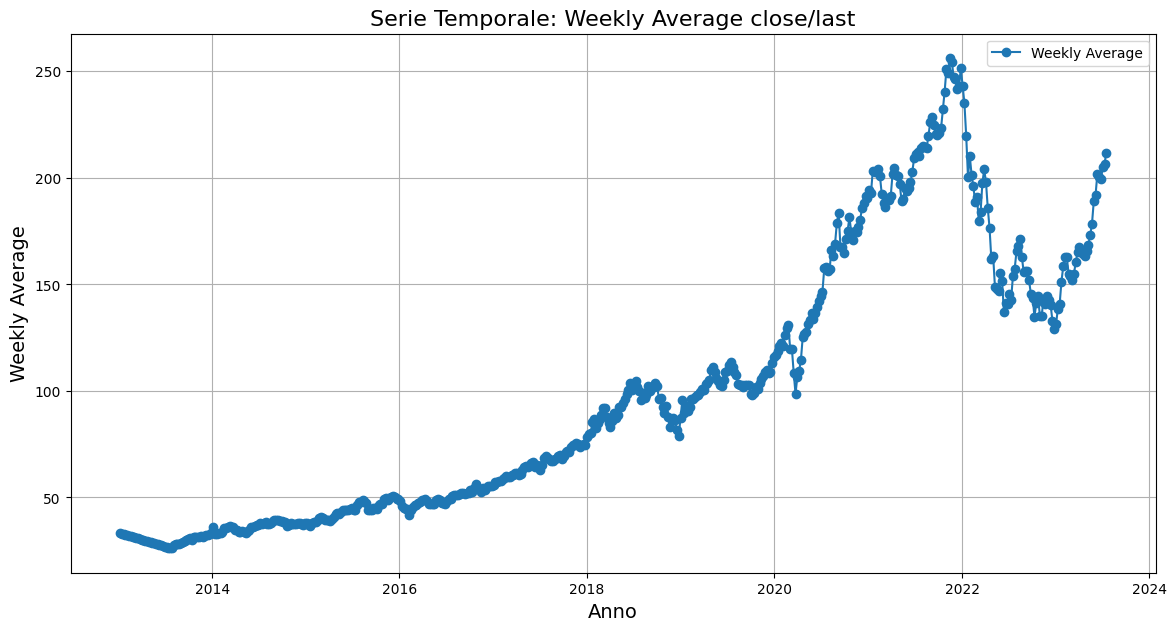

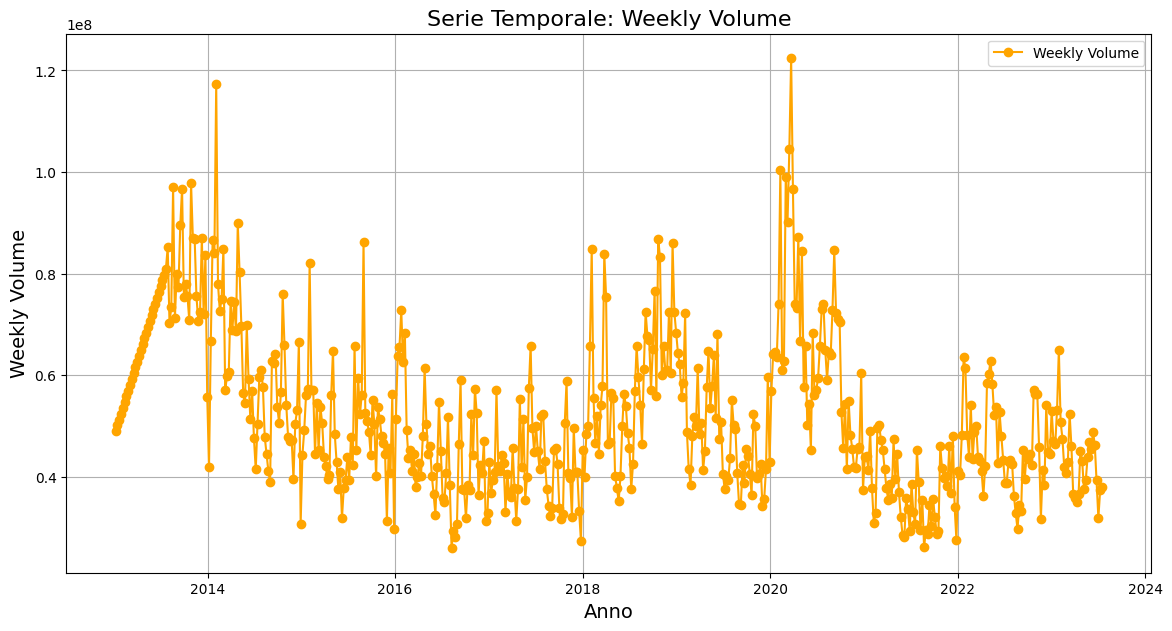

In [13]:
# Visualizzare la serie temporale per 'weekly_average'
plt.figure(figsize=(14, 7))
plt.plot(df_apple_weekly.index, df_apple_weekly['weekly_average'], label='Weekly Average', marker='o')
plt.title('Serie Temporale: Weekly Average close/last', fontsize=16)
plt.xlabel('Anno', fontsize=14)
plt.ylabel('Weekly Average', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Visualizzare la serie temporale per 'weekly_volume'
plt.figure(figsize=(14, 7))
plt.plot(df_apple_weekly.index, df_apple_weekly['weekly_volume'], label='Weekly Volume', color='orange', marker='o')
plt.title('Serie Temporale: Weekly Volume', fontsize=16)
plt.xlabel('Anno', fontsize=14)
plt.ylabel('Weekly Volume', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


## DECOMPOSIZIONE SERIE TEMPORALE

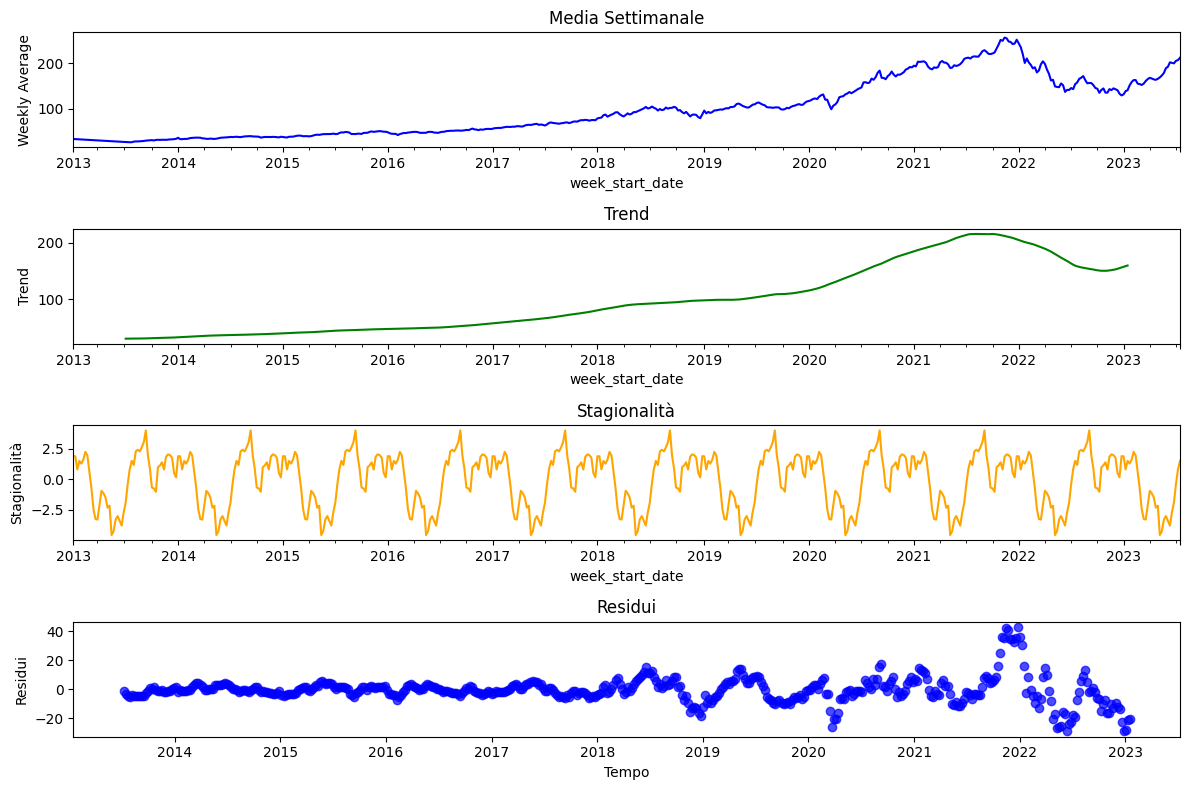

In [14]:
# Decomposizione della serie temporale
decomposizione = seasonal_decompose(df_apple_weekly['weekly_average'], model='additive', period=52)

# Creazione di una figura con dimensioni maggiori
fig, axes = plt.subplots(4, 1, figsize=(12, 8))  # Aumento delle dimensioni

# Media settimanale
decomposizione.observed.plot(ax=axes[0], title='Media Settimanale', color='blue')
axes[0].set_ylabel('Weekly Average')

# Trend
decomposizione.trend.plot(ax=axes[1], title='Trend', color='green')
axes[1].set_ylabel('Trend')

# Stagionalità
decomposizione.seasonal.plot(ax=axes[2], title='Stagionalità', color='orange')
axes[2].set_ylabel('Stagionalità')

# Residui con i pallini blu (scatter plot)
axes[3].scatter(decomposizione.resid.index, decomposizione.resid, color='blue', alpha=0.7)
axes[3].set_title('Residui')
axes[3].set_ylabel('Residui')
axes[3].set_xlabel('Tempo')

plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()



## Verifica stazionarietà serie temporale

In [15]:
# Test di Dickey-Fuller Aumentato
result = adfuller(df_apple_weekly['weekly_average'].dropna())

# Stampare i risultati del test
print("Test di Dickey-Fuller Aumentato:")
print(f"Statistiche del test: {result[0]}")
print(f"P-value: {result[1]}")
print("Valori critici:")
for key, value in result[4].items():
    print(f"   {key}: {value}")


Test di Dickey-Fuller Aumentato:
Statistiche del test: -0.5498752917829606
P-value: 0.8819107752125215
Valori critici:
   1%: -3.442701754304053
   5%: -2.866988120523906
   10%: -2.5696716542766693


❌ Non stazionaria, per questo la andremo a differenziare ⬇️

## Differenziazione serie temporale

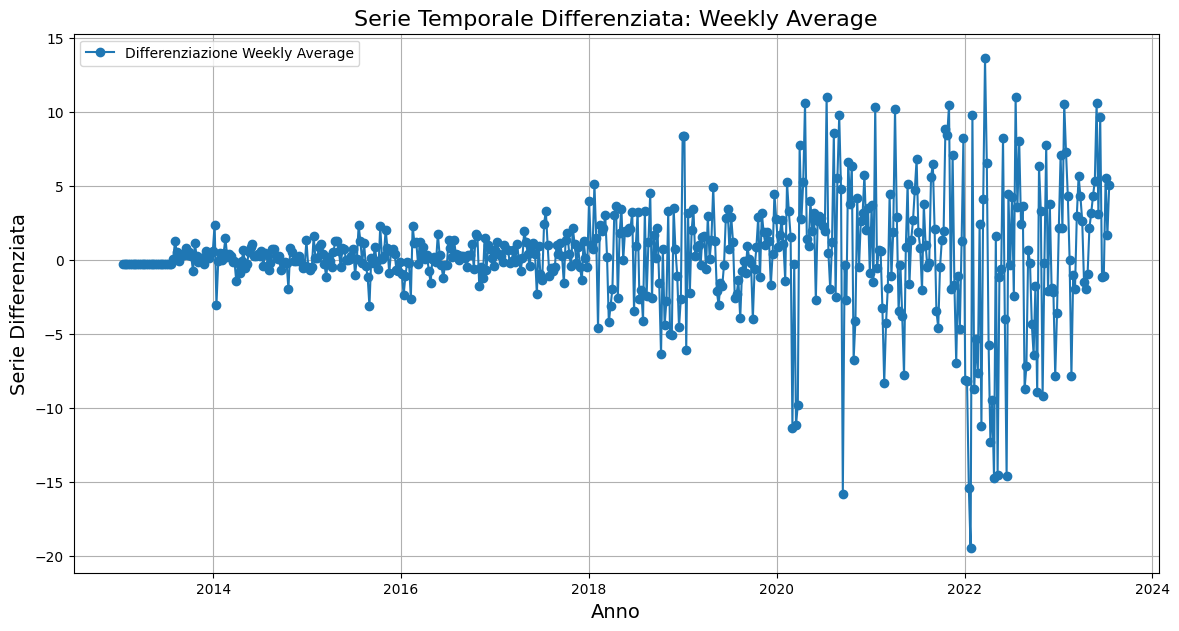

Test di Dickey-Fuller Aumentato (Serie Differenziata):
Statistiche del test: -3.4957266692101534
P-value: 0.00809752288793255
Valori critici:
   1%: -3.442772146350605
   5%: -2.8670191055991836
   10%: -2.5696881663873414


In [16]:
# Differenziare la serie temporale
df_apple_weekly['differenced_weekly_average'] = df_apple_weekly['weekly_average'].diff()

# Visualizzare la serie differenziata
plt.figure(figsize=(14, 7))
plt.plot(df_apple_weekly.index, df_apple_weekly['differenced_weekly_average'], label='Differenziazione Weekly Average', marker='o')
plt.title('Serie Temporale Differenziata: Weekly Average', fontsize=16)
plt.xlabel('Anno', fontsize=14)
plt.ylabel('Serie Differenziata', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

# Test di Dickey-Fuller Aumentato sulla serie differenziata
result_diff = adfuller(df_apple_weekly['differenced_weekly_average'].dropna())

# Stampare i risultati del test
print("Test di Dickey-Fuller Aumentato (Serie Differenziata):")
print(f"Statistiche del test: {result_diff[0]}")
print(f"P-value: {result_diff[1]}")
print("Valori critici:")
for key, value in result_diff[4].items():
    print(f"   {key}: {value}")


**Stima manuale ACF e PACF**

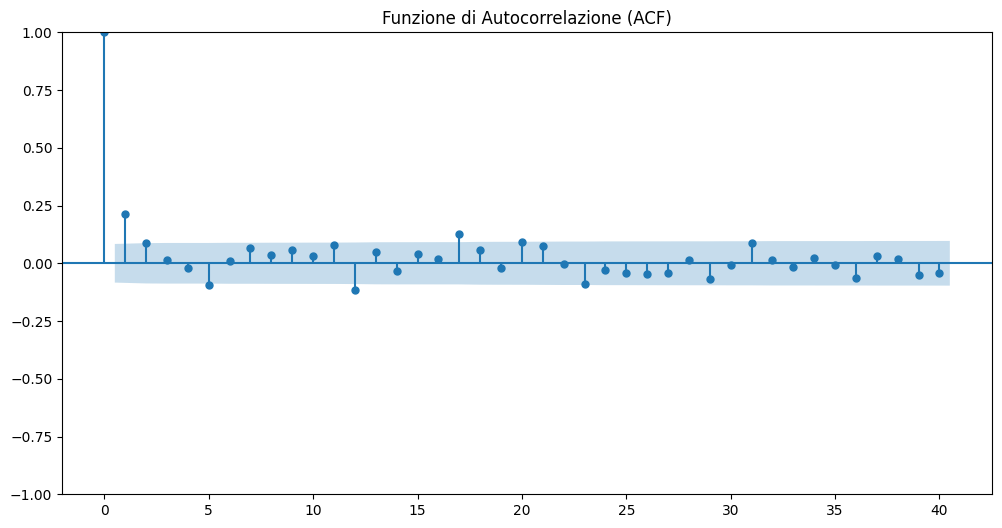

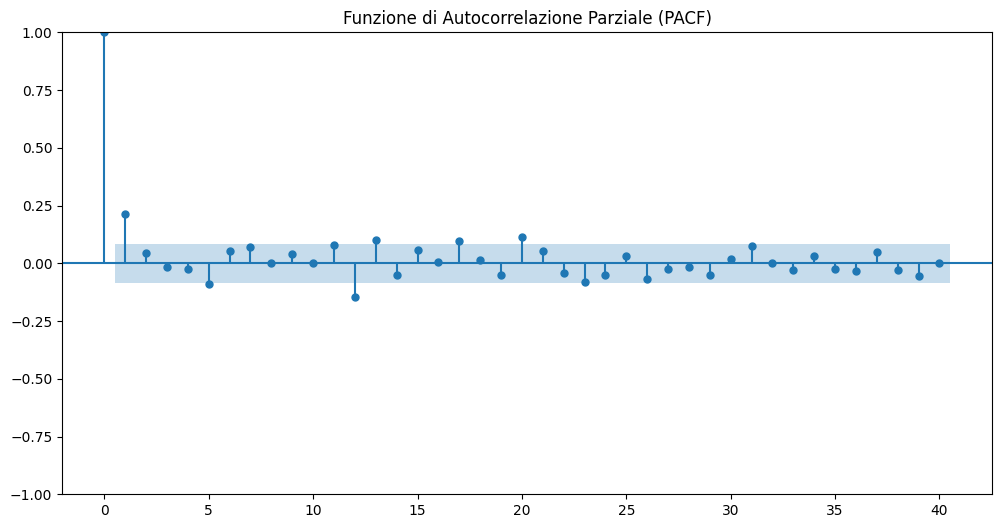

In [17]:
# Grafico ACF (Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_acf(df_apple_weekly['differenced_weekly_average'].dropna(), lags=40, ax=plt.gca())
plt.title('Funzione di Autocorrelazione (ACF)')
plt.show()

# Grafico PACF (Partial Autocorrelation Function)
plt.figure(figsize=(12, 6))
plot_pacf(df_apple_weekly['differenced_weekly_average'].dropna(), lags=40, ax=plt.gca(), method='ywm')
plt.title('Funzione di Autocorrelazione Parziale (PACF)')
plt.show()


Sulla base di questi grafici, possiamo iniziare a provare il modello ARIMA con i seguenti parametri:

- p=1 o p=2
- d=1 (differenziazione applicata)
- q=1 o q=2

**Ora stimiamo p e q in modo automatico**

Miglior modello ARIMA: ordine=(1, 1, 1), AIC=1424.4059802004983
                               SARIMAX Results                                
Dep. Variable:         weekly_average   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -709.203
Date:                Sun, 01 Dec 2024   AIC                           1424.406
Time:                        16:47:46   BIC                           1436.097
Sample:                    01-07-2013   HQIC                          1429.053
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6162      0.096     -6.431      0.000      -0.804      -0.428
ma.L1          0.7774      0.087      8.963      0.000       0.607 

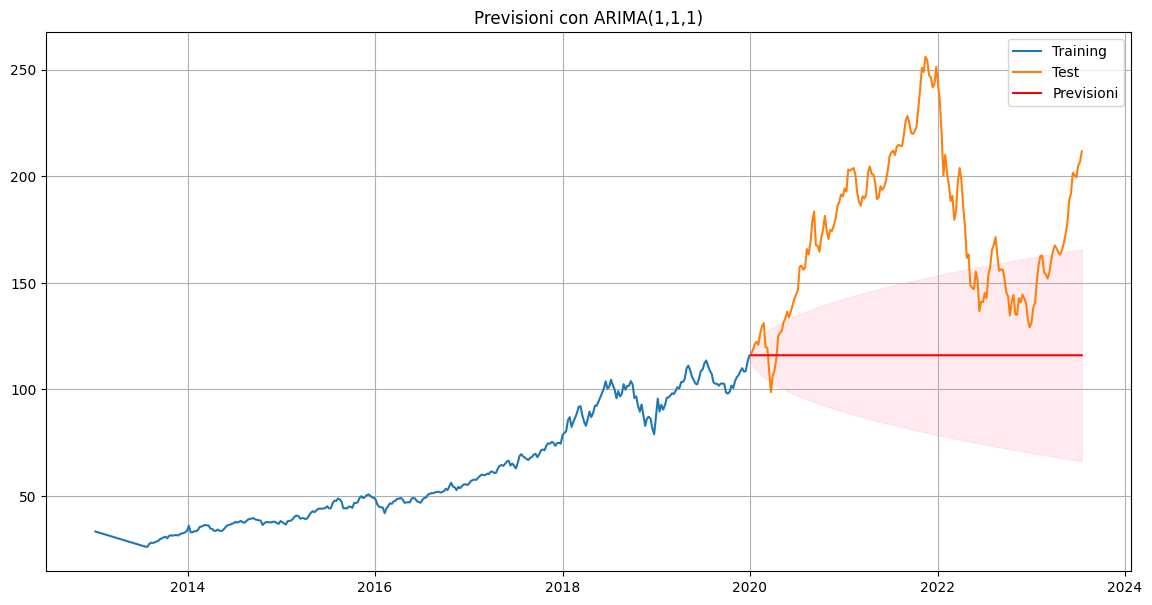

In [18]:
# Dividere il dataset in training e test
split_date = '2019-12-31'
train_data = df_apple_weekly[:split_date]['weekly_average']
test_data = df_apple_weekly[split_date:]['weekly_average']

# Parametri per il modello ARIMA
p = range(0, 3)  # Valori possibili di p (ordine autoregressivo)
d = [1]          # Differenziazione basata sull'analisi
q = range(0, 3)  # Valori possibili di q (ordine media mobile)

# Genera tutte le combinazioni di (p, d, q)
pdq = list(itertools.product(p, d, q))

# Variabili per tracciare il miglior modello
best_aic = float('inf')
best_order = None
best_model = None

# Itera su tutte le combinazioni di parametri
for param in pdq:
    try:
        # Adatta il modello ARIMA
        model = sm.tsa.ARIMA(train_data, order=param)
        results = model.fit()
        
        # Confronta l'AIC per trovare il modello migliore
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
            best_model = results
    except Exception as e:
        # Ignora gli errori e continua
        print(f"Errore con i parametri {param}: {e}")
        continue

# Stampa il miglior modello trovato
if best_order:
    print(f"Miglior modello ARIMA: ordine={best_order}, AIC={best_aic}")
else:
    print("Nessun modello ARIMA valido trovato.")

# Dettagli del miglior modello
if best_model:
    print(best_model.summary())

# Previsioni sul test set
if best_model:
    forecast = best_model.get_forecast(steps=len(test_data))
    forecast_ci = forecast.conf_int()

    # Visualizzazione dei risultati
    plt.figure(figsize=(14, 7))
    plt.plot(train_data, label='Training')
    plt.plot(test_data, label='Test')
    plt.plot(forecast.predicted_mean, label='Previsioni', color='red')
    plt.fill_between(forecast_ci.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title('Previsioni con ARIMA(1,1,1)')
    plt.legend()
    plt.grid(True)
    plt.show()


❌ Problema identificato:

Previsioni Piatte:
ARIMA(1, 1, 1) non cattura adeguatamente la dinamica dei dati di test, probabilmente a causa della mancanza di una componente stagionale.


In [19]:
# Previsioni effettive (forecast_mean)
forecast_mean = forecast.predicted_mean

# Calcolo delle metriche
mse = mean_squared_error(test_data, forecast_mean)
mae = mean_absolute_error(test_data, forecast_mean)
rmse = np.sqrt(mse)

# Stampa dei risultati
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 59.041429588829175
Mean Squared Error (MSE): 4681.412413539553
Root Mean Squared Error (RMSE): 68.42084779904114


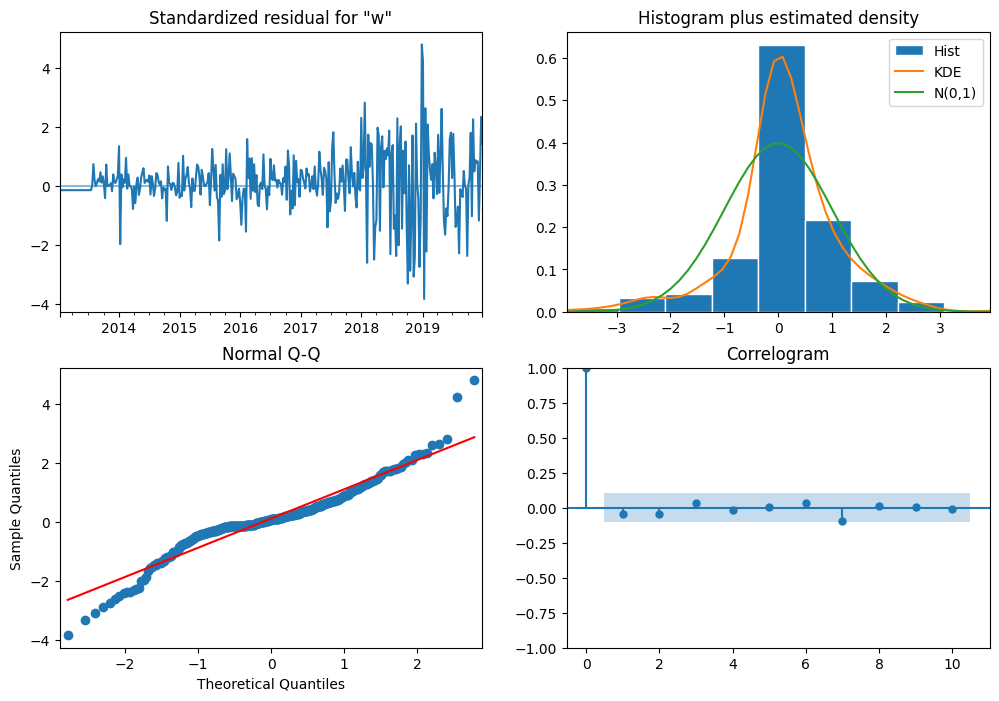

Test di Ljung-Box per i residui:
    lb_stat  lb_pvalue
10  1.87125   0.997235


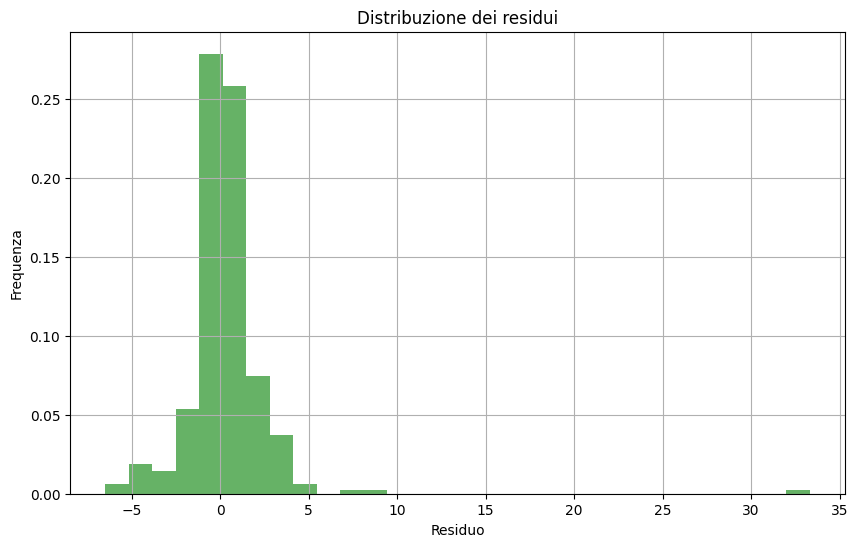

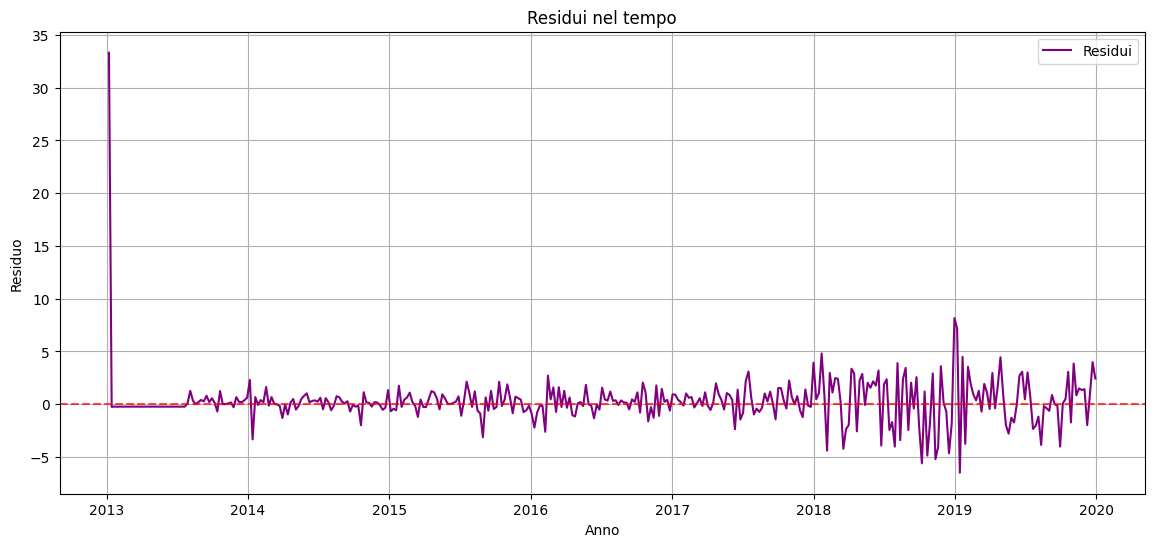

In [20]:
# Grafici diagnostici per il modello
best_model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Analisi dei residui
residuals = best_model.resid

# Test di Ljung-Box per l'autocorrelazione nei residui
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Test di Ljung-Box per i residui:")
print(ljung_box_results)

# Grafico della distribuzione dei residui
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
plt.title("Distribuzione dei residui")
plt.xlabel("Residuo")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

# Grafico dei residui nel tempo
plt.figure(figsize=(14, 6))
plt.plot(residuals, label='Residui', color='purple')
plt.axhline(0, linestyle='--', color='red', alpha=0.7)
plt.title("Residui nel tempo")
plt.xlabel("Anno")
plt.ylabel("Residuo")
plt.legend()
plt.grid(True)
plt.show()


❌ **Per avere un buon modello, la linea arancione dovrebbe essere simile alla linea verde (grafico diagnostico in alto a destra)**

## Confronto ARIMA (TROVO IL MIGLIORE ARIMA)

In [ ]:
# Definizione dei parametri da confrontare
p = range(0, 3)  # Valori possibili di p
d = [1]          # Differenziazione fissa (già verificata)
q = range(0, 3)  # Valori possibili di q
pdq = list(itertools.product(p, d, q))

# Dividi i dati in training e test
split_date = '2019-12-31'
train_data = df_apple_weekly[:split_date]['weekly_average']
test_data = df_apple_weekly[split_date:]['weekly_average']

# Variabili per memorizzare i risultati
results_summary = []

# Adatta e valuta ogni modello
for param in pdq:
    try:
        # Adatta il modello ARIMA
        model = ARIMA(train_data, order=param)
        fitted_model = model.fit()
        
        # Previsioni sui dati di test
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Calcolo delle metriche di accuratezza
        mae = mean_absolute_error(test_data, forecast)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
        
        # Salva i risultati
        results_summary.append({
            'Model': f"ARIMA{param}",
            'AIC': fitted_model.aic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })
    except Exception as e:
        print(f"Errore con i parametri {param}: {e}")
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i risultati ordinati
print("Confronto tra Modelli ARIMA:")
for result in results_summary:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")

# Visualizza i primi 3 modelli
print("\nTop 3 modelli migliori in base all'AIC:")
for result in results_summary[:3]:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")


Confronto tra Modelli ARIMA:
Modello: ARIMA(1, 1, 1), AIC: 1424.41, MAE: 59.04, RMSE: 68.42, MAPE: 31.12%
Modello: ARIMA(2, 1, 1), AIC: 1424.68, MAE: 59.37, RMSE: 68.72, MAPE: 31.31%
Modello: ARIMA(1, 1, 2), AIC: 1424.94, MAE: 59.37, RMSE: 68.72, MAPE: 31.31%
Modello: ARIMA(2, 1, 2), AIC: 1425.76, MAE: 59.28, RMSE: 68.64, MAPE: 31.26%
Modello: ARIMA(0, 1, 2), AIC: 1427.00, MAE: 59.79, RMSE: 69.10, MAPE: 31.56%
Modello: ARIMA(2, 1, 0), AIC: 1430.94, MAE: 59.71, RMSE: 69.03, MAPE: 31.51%
Modello: ARIMA(0, 1, 1), AIC: 1433.40, MAE: 58.88, RMSE: 68.27, MAPE: 31.03%
Modello: ARIMA(1, 1, 0), AIC: 1434.44, MAE: 58.88, RMSE: 68.28, MAPE: 31.03%
Modello: ARIMA(0, 1, 0), AIC: 1435.35, MAE: 59.14, RMSE: 68.51, MAPE: 31.18%

Top 3 modelli migliori in base all'AIC:
Modello: ARIMA(1, 1, 1), AIC: 1424.41, MAE: 59.04, RMSE: 68.42, MAPE: 31.12%
Modello: ARIMA(2, 1, 1), AIC: 1424.68, MAE: 59.37, RMSE: 68.72, MAPE: 31.31%
Modello: ARIMA(1, 1, 2), AIC: 1424.94, MAE: 59.37, RMSE: 68.72, MAPE: 31.31%


**Il modello ARIMA(1, 1, 1) ha il valore AIC più basso, il che lo rende il miglior modello in termini di adattamento ai dati.**

p = 1 (numero di termini autoregressivi),
d = 1 (grado di differenziazione, già fisso nel tuo caso),
q = 1 (numero di termini della media mobile).

## DIVISIONE DATASET

In [21]:
# Filtrare i dati dalla fase di ETL già effettuata
# df_apple_weekly è il DataFrame elaborato nella fase di ETL

# Conferma delle colonne
print("Conferma delle colonne in df_apple_weekly:")
print(df_apple_weekly.columns)

# Suddivisione del dataset in training e test
split_date = '2019-12-31'  # Data di separazione tra training e test
train_data = df_apple_weekly.loc[:split_date, 'weekly_average']
test_data = df_apple_weekly.loc[split_date:, 'weekly_average']

# Conferma della suddivisione
print(f"Numero di osservazioni nel training set: {len(train_data)}")
print(f"Numero di osservazioni nel test set: {len(test_data)}")

# Visualizza le prime righe di training e test
print("\nPrime righe del training set:")
print(train_data.head())
print("\nPrime righe del test set:")
print(test_data.head())


Conferma delle colonne in df_apple_weekly:
Index(['weekly_average', 'weekly_volume', 'week_label', 'week_number',
       'differenced_weekly_average'],
      dtype='object')
Numero di osservazioni nel training set: 365
Numero di osservazioni nel test set: 185

Prime righe del training set:
week_start_date
2013-01-07    33.320590
2013-01-14    33.065022
2013-01-21    32.809455
2013-01-28    32.553887
2013-02-04    32.298319
Name: weekly_average, dtype: float64

Prime righe del test set:
week_start_date
2020-01-06    116.867600
2020-01-13    118.589694
2020-01-20    121.306068
2020-01-27    122.400715
2020-02-03    121.023782
Name: weekly_average, dtype: float64


## Applicazione modello SARIMA 

IN QUESTA SEZIONE (⬇️) HO CAPITO CHE ARIMA NON È IL TOP, PROVO CON SARIMA E CONFRONTO

In [ ]:
# Definizione dei parametri per il modello SARIMA
p = range(0, 3)  # Parametri autoregressivi
d = [1]          # Differenziazione
q = range(0, 3)  # Parametri della media mobile
P = range(0, 2)  # Parametri stagionali autoregressivi
D = [1]          # Differenziazione stagionale
Q = range(0, 2)  # Parametri stagionali della media mobile
s = [52]         # Stagionalità settimanale (52 settimane per anno)

# Genera tutte le combinazioni di parametri SARIMA
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Variabili per memorizzare i risultati
results_summary = []

# Ciclo per valutare ogni combinazione di parametri
for param in param_combinations:
    try:
        # Definisci il modello SARIMA
        model = SARIMAX(train_data, order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], param[6]),
                        enforce_stationarity=False, enforce_invertibility=False)
        # Adatta il modello
        fitted_model = model.fit(disp=False)
        
        # Previsioni sui dati di test
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Calcola le metriche di accuratezza
        mae = mean_absolute_error(test_data, forecast)
        rmse = np.sqrt(mean_squared_error(test_data, forecast))
        mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
        
        # Salva i risultati
        results_summary.append({
            'Model': f"SARIMA{param}",
            'AIC': fitted_model.aic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })
    except Exception as e:
        # Ignora i parametri che causano errori
        print(f"Errore con i parametri {param}: {e}")
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i risultati ordinati
print("Confronto tra Modelli SARIMA:")
for result in results_summary:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")

# Mostra i primi 3 modelli migliori in base all'AIC
print("\nTop 3 modelli migliori in base all'AIC:")
for result in results_summary[:3]:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")


Confronto tra Modelli SARIMA:
Modello: SARIMA(0, 1, 2, 1, 1, 1, 52), AIC: 1100.25, MAE: 36.46, RMSE: 45.47, MAPE: 19.27%
Modello: SARIMA(1, 1, 2, 1, 1, 1, 52), AIC: 1100.71, MAE: 36.42, RMSE: 45.35, MAPE: 19.27%
Modello: SARIMA(2, 1, 2, 1, 1, 1, 52), AIC: 1102.46, MAE: 36.66, RMSE: 46.14, MAPE: 19.25%
Modello: SARIMA(1, 1, 1, 1, 1, 1, 52), AIC: 1103.22, MAE: 36.41, RMSE: 45.31, MAPE: 19.27%
Modello: SARIMA(2, 1, 1, 1, 1, 1, 52), AIC: 1104.61, MAE: 36.42, RMSE: 45.35, MAPE: 19.27%
Modello: SARIMA(2, 1, 1, 1, 1, 0, 52), AIC: 1105.59, MAE: 36.56, RMSE: 45.45, MAPE: 19.40%
Modello: SARIMA(0, 1, 2, 0, 1, 1, 52), AIC: 1106.07, MAE: 37.37, RMSE: 48.42, MAPE: 19.23%
Modello: SARIMA(2, 1, 0, 1, 1, 1, 52), AIC: 1106.13, MAE: 36.44, RMSE: 45.40, MAPE: 19.28%
Modello: SARIMA(0, 1, 1, 1, 1, 1, 52), AIC: 1106.68, MAE: 36.40, RMSE: 45.26, MAPE: 19.28%
Modello: SARIMA(1, 1, 2, 0, 1, 1, 52), AIC: 1106.74, MAE: 37.35, RMSE: 48.41, MAPE: 19.21%
Modello: SARIMA(2, 1, 0, 1, 1, 0, 52), AIC: 1106.80, MAE: 36

## APPLICAZIONE MIGLIOR MODELLO SARIMA

                                      SARIMAX Results                                       
Dep. Variable:                       weekly_average   No. Observations:                  365
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 52)   Log Likelihood                -545.124
Date:                              Sat, 30 Nov 2024   AIC                           1100.247
Time:                                      13:31:37   BIC                           1117.993
Sample:                                  01-07-2013   HQIC                          1107.384
                                       - 12-30-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1460      0.044      3.355      0.001       0.061       0.231
ma.L2         -0.14

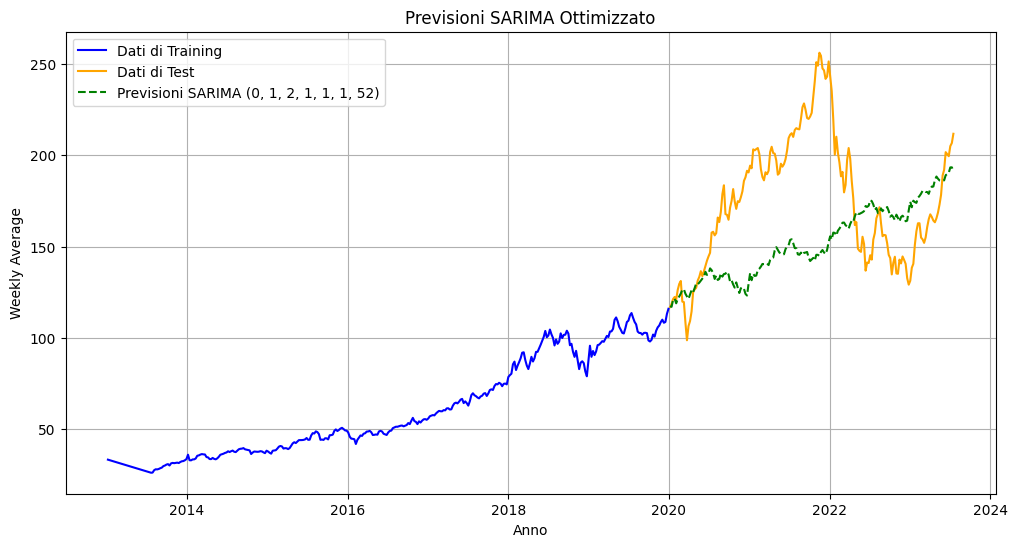

In [ ]:
# Parametri del miglior modello SARIMA trovato
best_params = (0, 1, 2, 1, 1, 1, 52)

# Adatta il modello SARIMA con i parametri ottimali
model = SARIMAX(
    train_data,  # train_data è già la serie 'weekly_average'
    order=(best_params[0], best_params[1], best_params[2]),
    seasonal_order=(best_params[3], best_params[4], best_params[5], best_params[6]),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Adattamento del modello
fitted_model = model.fit(disp=False)

# Stampa il sommario del modello
print(fitted_model.summary())

# Previsioni con il modello ottimizzato
forecast = fitted_model.forecast(steps=len(test_data))

# Riallinea l'indice delle previsioni con i dati di test
forecast.index = test_data.index

# Calcolo delle metriche di accuratezza
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

print(f"MAE del modello ottimizzato: {mae:.2f}")
print(f"RMSE del modello ottimizzato: {rmse:.2f}")
print(f"MAPE del modello ottimizzato: {mape:.2f}%")

# Grafico delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Dati di Training", color="blue")
plt.plot(test_data, label="Dati di Test", color="orange")
plt.plot(forecast, label=f"Previsioni SARIMA {best_params}", linestyle="--", color="green")
plt.title("Previsioni SARIMA Ottimizzato")
plt.xlabel("Anno")
plt.ylabel("Weekly Average")
plt.legend()
plt.grid()
plt.show()


✅ **Il modello SARIMA ottimizzato sta performando meglio rispetto al modello ARIMA**

Metriche e previsioni accettabili

## GRAFICI DIAGNOSTICI SARIMA

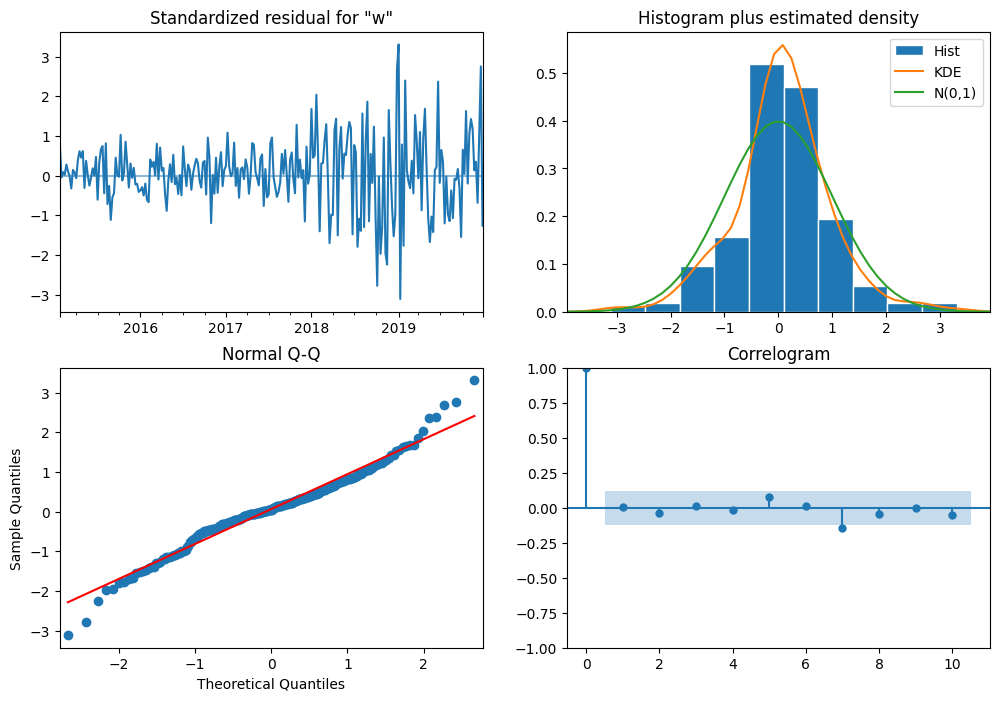

In [24]:
fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()

## OTTIMIZZAZIONE E APPLICAZIONE SARIMAX

**Le previsioni dovrebbero ora essere più accurate, includendo variabili esogene come weekly_volume.**

Migliori parametri SARIMAX: (1, 1, 1, 0, 1, 1, 52), AIC: 1321.51
                                     SARIMAX Results                                      
Dep. Variable:                     weekly_average   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -655.755
Date:                            Sat, 30 Nov 2024   AIC                           1321.511
Time:                                    13:59:50   BIC                           1340.226
Sample:                                01-07-2013   HQIC                          1328.991
                                     - 12-30-2019                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
weekly_volume -3.599e-08    1.2e-08     -3.

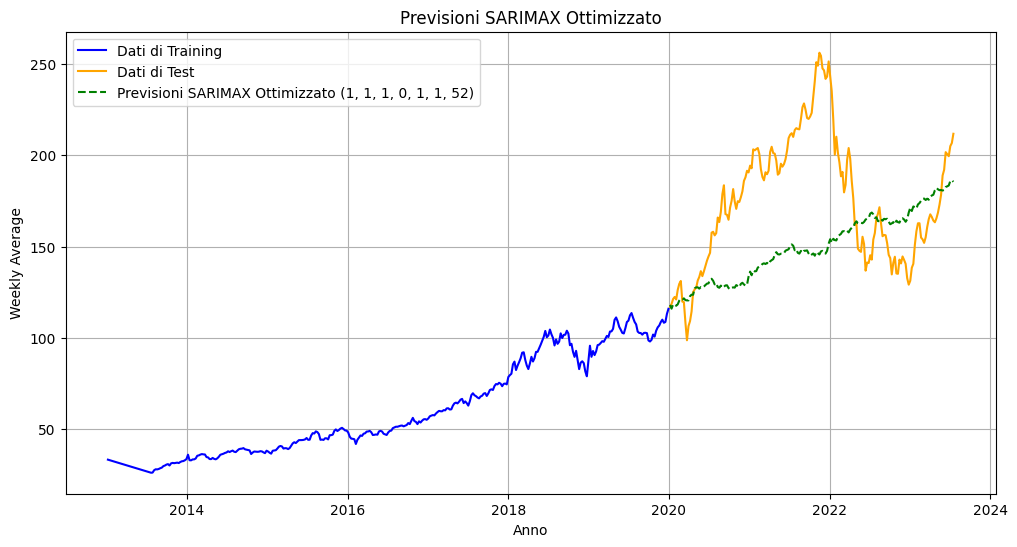

In [ ]:
# Definizione dei range di parametri
p = range(0, 3)   # Ordine AR
d = [1]           # Differenziazione
q = range(0, 3)   # Ordine MA
P = range(0, 3)   # Ordine stagionale AR
D = [1]           # Differenziazione stagionale
Q = range(0, 3)   # Ordine stagionale MA
s = [52]          # Periodo stagionale (settimanale)

# Genera tutte le combinazioni possibili di parametri
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Variabili per memorizzare i risultati
best_aic = float('inf')
best_params = None
best_model = None
results_summary = []

# Usa i dati già definiti
train_data = df_apple_weekly.loc[:split_date, 'weekly_average']
test_data = df_apple_weekly.loc[split_date:, 'weekly_average']
train_data_weekly_volume = df_apple_weekly.loc[:split_date, 'weekly_volume']
test_data_weekly_volume = df_apple_weekly.loc[split_date:, 'weekly_volume']

# Ciclo su tutte le combinazioni di parametri
for param in param_combinations:
    try:
        # Adatta il modello SARIMAX con weekly_volume come variabile esogena
        model = SARIMAX(
            train_data,  # weekly_average come target
            exog=train_data_weekly_volume,  # weekly_volume come variabile esogena
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], param[6])
        )
        results = model.fit(disp=False)
        
        # Confronta l'AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = results
        
        # Salva i risultati
        results_summary.append({
            'Params': param,
            'AIC': results.aic
        })
    except Exception as e:
        print(f"Errore con i parametri {param}: {e}")
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i migliori parametri
if best_params:
    print(f"Migliori parametri SARIMAX: {best_params}, AIC: {best_aic:.2f}")
else:
    print("Nessun modello valido trovato.")

# Dettagli del miglior modello
if best_model:
    print(best_model.summary())

# Previsioni con il modello ottimizzato
if best_model:
    forecast = best_model.forecast(steps=len(test_data), exog=test_data_weekly_volume)

    # Riallinea l'indice delle previsioni con i dati di test
    forecast.index = test_data.index

    # Calcolo delle metriche di accuratezza
    mae = mean_absolute_error(test_data, forecast)
    rmse = np.sqrt(mean_squared_error(test_data, forecast))

    print(f"MAE del modello ottimizzato: {mae:.2f}")
    print(f"RMSE del modello ottimizzato: {rmse:.2f}")

    # Grafico delle previsioni
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label="Dati di Training", color="blue")
    plt.plot(test_data, label="Dati di Test", color="orange")
    plt.plot(forecast, label=f"Previsioni SARIMAX Ottimizzato {best_params}", linestyle="--", color="green")
    plt.title("Previsioni SARIMAX Ottimizzato")
    plt.xlabel("Anno")
    plt.ylabel("Weekly Average")
    plt.legend()
    plt.grid()
    plt.show()


✅ **Il modello SARIMAX performa meglio rispetto ad ARIMA e SARIMA**

## GRAFICI DIAGNOSTICI SARIMAX

                                     SARIMAX Results                                      
Dep. Variable:                     weekly_average   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -550.769
Date:                            Sun, 01 Dec 2024   AIC                           1111.538
Time:                                    16:49:09   BIC                           1129.303
Sample:                                01-07-2013   HQIC                          1118.681
                                     - 12-30-2019                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
weekly_volume -3.599e-08   1.24e-08     -2.897      0.004   -6.03e-08   -1.16e-08
ar.L1            -0.5836  

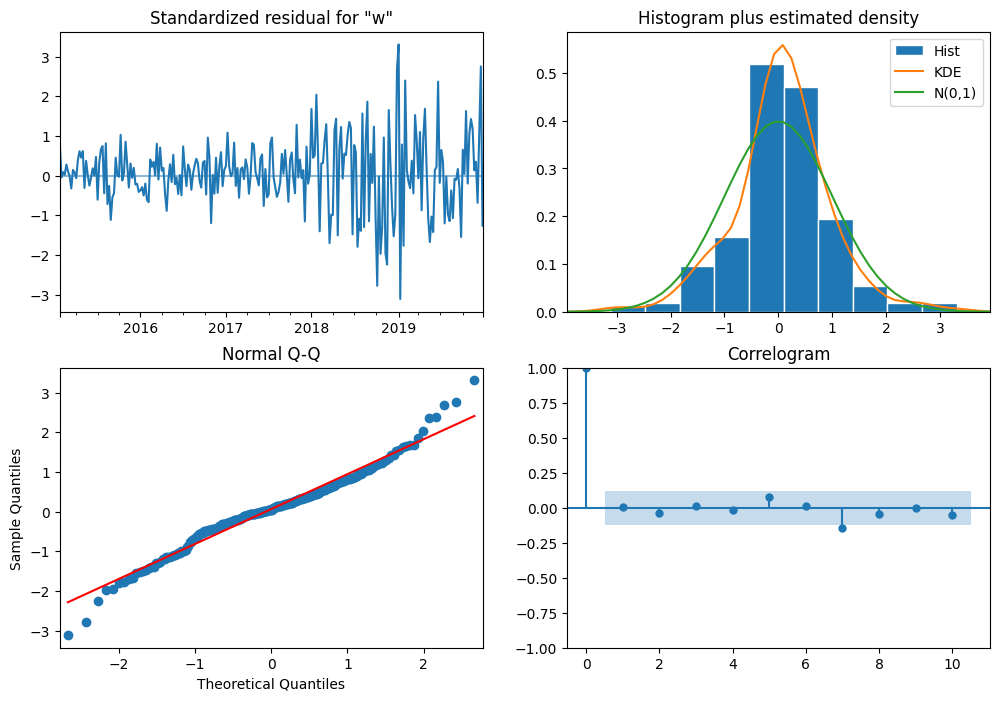

In [23]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assumiamo che il dataset df_apple_weekly sia già definito
# Filtrare i dati per training e test
split_date = '2019-12-31'
train_data = df_apple_weekly.loc[:split_date, 'weekly_average']  # Variabile target
test_data = df_apple_weekly.loc[split_date:, 'weekly_average']

train_data_weekly_volume = df_apple_weekly.loc[:split_date, 'weekly_volume']  # Variabile esogena
test_data_weekly_volume = df_apple_weekly.loc[split_date:, 'weekly_volume']

# Adattare il modello SARIMAX con i parametri forniti
sarimax_model = SARIMAX(
    train_data,  # weekly_average come target
    exog=train_data_weekly_volume,  # weekly_volume come variabile esogena
    order=(1, 1, 1),  # Parametri ARIMA (p, d, q)
    seasonal_order=(0, 1, 1, 52),  # Parametri stagionali (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Adattamento del modello
fitted_model = sarimax_model.fit(disp=False)

# Stampa del sommario del modello
print(fitted_model.summary())

# Generare i grafici diagnostici
fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()


**CALCOLO LE METRICHE DI SARIMAX**

In [ ]:
# Dati reali (actual) e previsione (forecast)
actual = test_data.values  # Valori reali del test set (weekly_average)

# Prepara i dati esogeni per il test set (ad esempio, 'weekly_volume' è la variabile esogena)
exog_test = test_data_weekly_volume.values.reshape(-1, 1)  # Variabile esogena per il test set

# Ottieni il forecast dal modello SARIMAX ottimizzato
forecast = best_model.get_forecast(steps=len(test_data), exog=exog_test).predicted_mean.values

# Calcolo delle metriche
me = np.mean(forecast - actual)  # Mean Error (ME)
mae = np.mean(np.abs(forecast - actual))  # Mean Absolute Error (MAE)
mpe = np.mean((forecast - actual) / actual) * 100  # Mean Percentage Error (MPE)
mape = np.mean(np.abs((forecast - actual) / actual)) * 100  # Mean Absolute Percentage Error (MAPE)
rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # Root Mean Squared Error (RMSE)

# Calcolo di ACF1 (Autocorrelazione dei residui al lag 1)
error = forecast - actual  # Calcola l'errore
acf1 = acf(error, nlags=1, fft=False)[1]  # Lag 1 Autocorrelation of Error (ACF1)

# Correlazione tra valori reali e previsione
corr = np.corrcoef(actual, forecast)[0, 1]  # Correlation between Actual and Forecast

# Min-Max Error
minmax = np.mean(np.abs(forecast - actual) / (np.max(actual) - np.min(actual)))  # Min-Max Error

# Creazione di una tabella con i risultati
metrics = {
    "Metric": ["ME", "MAE", "MPE", "MAPE", "RMSE", "ACF1", "Corr", "Min-Max Error"],
    "Value": [me, mae, mpe, mape, rmse, acf1, corr, minmax]
}

metrics_df = pd.DataFrame(metrics)

# Stampa della tabella
print("Metriche di valutazione del modello SARIMAX:")
print(metrics_df.to_string(index=False))


Metriche di valutazione del modello SARIMAX:
       Metric      Value
           ME -25.000120
          MAE  36.227268
          MPE -11.117939
         MAPE  19.041305
         RMSE  45.314182
         ACF1   0.985515
         Corr   0.130670
Min-Max Error   0.230084


## CONFRONTO METRICHE DEI MODELLI

In [ ]:
# Modello ARIMA(1, 1, 1)
arima_model = ARIMA(train_data, order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=len(test_data))

# Metriche per ARIMA
arima_mse = mean_squared_error(test_data, arima_forecast)
arima_mae = mean_absolute_error(test_data, arima_forecast)
arima_aic = arima_model.aic

# Modello SARIMA(0, 1, 2)x(1, 1, [1], 52)
sarima_model = SARIMAX(train_data, order=(0, 1, 2), seasonal_order=(1, 1, 1, 52)).fit(disp=False)
sarima_forecast = sarima_model.forecast(steps=len(test_data))

# Metriche per SARIMA
sarima_mse = mean_squared_error(test_data, sarima_forecast)
sarima_mae = mean_absolute_error(test_data, sarima_forecast)
sarima_aic = sarima_model.aic

# Modello SARIMAX(1, 1, 1, 0, 1, 1, 52)
sarimax_model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)
sarimax_forecast = sarimax_model.forecast(steps=len(test_data))

# Metriche per SARIMAX
sarimax_mse = mean_squared_error(test_data, sarimax_forecast)
sarimax_mae = mean_absolute_error(test_data, sarimax_forecast)
sarimax_aic = sarimax_model.aic

# Creazione della tabella di confronto
metrics_comparison = pd.DataFrame({
    "Model": ["ARIMA(1,1,1)", "SARIMA(0,1,2)x(1,1,[1],52)", "SARIMAX(1,1,1,0,1,1,52)"],
    "MSE": [arima_mse, sarima_mse, sarimax_mse],
    "MAE": [arima_mae, sarima_mae, sarimax_mae],
    "AIC": [arima_aic, sarima_aic, sarimax_aic]
})

# Visualizzazione della tabella
print("Confronto delle metriche di bontà dei modelli:")
print(metrics_comparison)


Confronto delle metriche di bontà dei modelli:
                        Model          MSE        MAE          AIC
0                ARIMA(1,1,1)  4681.412415  59.041430  1424.405980
1  SARIMA(0,1,2)x(1,1,[1],52)  2041.718878  36.342870  1309.189085
2     SARIMAX(1,1,1,0,1,1,52)  2159.692017  36.538858  1310.171317


✅ Conclusione: SARIMAX(1,1,1,0,1,1,52) è un modello competitivo, ma leggermente meno efficace rispetto a SARIMA.
Decisione:
Il modello SARIMA(0,1,2)x(1,1,[1],52) si dimostra il più performante in termini di precisione (MSE, MAE) e adattamento (AIC). È quindi il modello raccomandato per la serie temporale analizzata.